# Optimizaciones de GCC

En estos apuntes se presentan gráficas de los tiempos de ejecución, para una función que suma los elementos de dos arreglos de vectores y almacena el resultado en otro vector. La función será compilada con optimizaciones para observar como estas afectan al tiempo de ejecución y a la precisión. 

## Dependencias

In [1]:
import ctypes
import numpy
from numpy import linalg as LA

## Suma de arreglos de floats

In [2]:
%%file vectorFloatAdd.c
// funcion que suma dos arrays de floats
void vectorFloatAdd(float* a, float* b, float* c, int size){
    for(int i = 0; i < size; i++){
        c[i] = a[i] + b[i];
    }
}

Writing vectorFloatAdd.c


In [3]:
# crear el object file
! gcc -c -Wall -Werror -fpic -O0 vectorFloatAdd.c -o vectorFloatAddO0.o
! gcc -c -Wall -Werror -fpic -O1 vectorFloatAdd.c -o vectorFloatAddO1.o
! gcc -c -Wall -Werror -fpic -O2 vectorFloatAdd.c -o vectorFloatAddO2.o
! gcc -c -Wall -Werror -fpic -O3 vectorFloatAdd.c -o vectorFloatAddO3.o
! gcc -c -Wall -Werror -fpic -Os vectorFloatAdd.c -o vectorFloatAddOs.o

# crear la shared library
! gcc -shared vectorFloatAddO0.o -o _vectorFloatAddO0.so
! gcc -shared vectorFloatAddO1.o -o _vectorFloatAddO1.so
! gcc -shared vectorFloatAddO2.o -o _vectorFloatAddO2.so
! gcc -shared vectorFloatAddO3.o -o _vectorFloatAddO3.so
! gcc -shared vectorFloatAddOs.o -o _vectorFloatAddOs.so

In [4]:
def ctypes_vector_float_add(libfile):
    # cargar la shared library
    lib = ctypes.CDLL(libfile)
    # tipo de dato de los argumentos
    lib.vectorFloatAdd.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        ctypes.c_int
    ]
     # funcion configurada
    return lib.vectorFloatAdd

In [5]:
cvfaddO0 = ctypes_vector_float_add('./_vectorFloatAddO0.so')
cvfaddO1 = ctypes_vector_float_add('./_vectorFloatAddO1.so')
cvfaddO2 = ctypes_vector_float_add('./_vectorFloatAddO2.so')
cvfaddO3 = ctypes_vector_float_add('./_vectorFloatAddO3.so')
cvfaddOs = ctypes_vector_float_add('./_vectorFloatAddOs.so')

### Comparación de los errores relativos y tiempos de ejecución

In [6]:
# modulo para poder usar estadisticas
import statistics

# funcion para eliminar el ruido de una lista
from utilities import filtro_mediana

In [7]:
# modulo para graficar
import matplotlib.pyplot as plt

# modulo para medir el tiempo
import time

In [8]:
# nombres de las optimizaciones
optis = ['O0','O1','O2','O3','Os']

# funciones
funcs = [cvfaddO0, cvfaddO1, cvfaddO2, cvfaddO3, cvfaddOs]

# colores
colores = ['r-o','g-o','b-o','y-o','c-o']

# tamagnos de los arreglos
sizes = 2**numpy.arange(10,21)

# errores de la suma de arreglos de floats
errs = [
    numpy.zeros((len(sizes),1),dtype=numpy.float64),
    numpy.zeros((len(sizes),1),dtype=numpy.float64),
    numpy.zeros((len(sizes),1),dtype=numpy.float64),
    numpy.zeros((len(sizes),1),dtype=numpy.float64),
    numpy.zeros((len(sizes),1),dtype=numpy.float64)
]

# tiempos de la suma de arreglos de floats
tiemps = [
    numpy.zeros((len(sizes),1),dtype=numpy.float64),
    numpy.zeros((len(sizes),1),dtype=numpy.float64),
    numpy.zeros((len(sizes),1),dtype=numpy.float64),
    numpy.zeros((len(sizes),1),dtype=numpy.float64),
    numpy.zeros((len(sizes),1),dtype=numpy.float64)
]

# cantidad de repeticiones
veces = 50

# diccionario de datos
dct = dict(
    map(lambda a, b, c, d, e : (a, {'color': b, 'error': c, 'tiempo': d, 'func': e}), optis, colores, errs, tiemps, funcs)
)

In [9]:
# mediciones de los errores relativos con cada optimización
for key in dct:
    for i,size in enumerate(sizes):
        ei = []
        for j in range(veces):
            # entradas
            x = numpy.random.rand(size,1).astype(numpy.float32)
            y = numpy.random.rand(size,1).astype(numpy.float32)
            # salida
            z = numpy.zeros((size,1),dtype=numpy.float32)
            # referencia
            r = numpy.zeros((size,1),dtype=numpy.float32)
            r = x + y
            # llamada a funcion
            dct[key]['func'](x,y,z,size)
            # medir error y listarlo
            ei.append(LA.norm(r-z)/LA.norm(r))
        dct[key]['error'][i] = statistics.mean(ei)

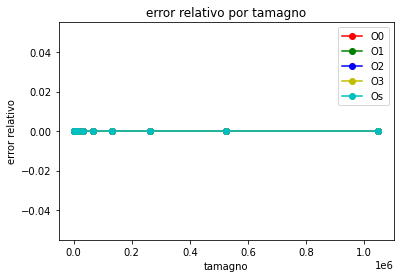

In [10]:
# grafico de los errores relativos para cada tamagno
for key in dct:
    plt.plot(sizes,dct[key]['error'],dct[key]['color'],label=key)
plt.title('error relativo por tamagno')
plt.xlabel('tamagno')
plt.ylabel('error relativo')
plt.legend()
plt.show()

La gráfica de errores relativos da la impresión de solo mostrar la precisón obtenido para la optimización Os, pero lo que ocurre es que todas las curvas están solapadas, y por eso no se aprecian.

In [11]:
# luego de comprobar que todas las funciones son precisas
# se pueden realizar mediciones de tiempo para cada tamagno
for key in dct:
    for i,size in enumerate(sizes):
        ti = []
        for j in range(veces):
            # entradas
            x = numpy.random.rand(size,1).astype(numpy.float32)
            y = numpy.random.rand(size,1).astype(numpy.float32)
            # salida
            z = numpy.zeros((size,1),dtype=numpy.float32)
            # medir tiempo
            t = time.time()
            # llamada a func
            dct[key]['func'](x,y,z,size)
            # medir tiempo y listar diferencia
            ti.append(time.time() - t)
        dct[key]['tiempo'][i] = statistics.mean(filtro_mediana(ti,9))

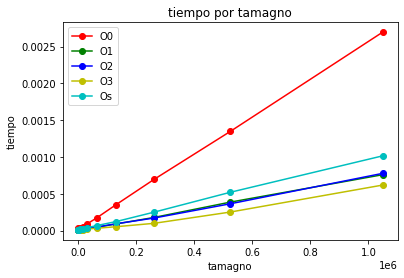

In [12]:
# grafico de los tiempos promedio por cada tamagno
for key in dct:
    plt.plot(sizes,dct[key]['tiempo'],dct[key]['color'],label=key)
plt.title('tiempo por tamagno')
plt.xlabel('tamagno')
plt.ylabel('tiempo')
plt.legend()
plt.show()

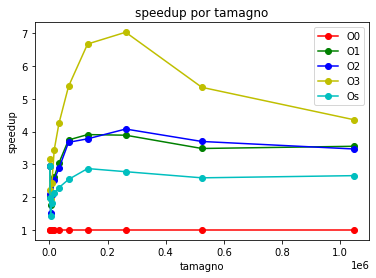

In [13]:
# grafica de los speedup para cada tamagno segun la optimizacion empleada
# el tiempo obtenido con O0 es la referencia
for key in dct:
    plt.plot(sizes,dct['O0']['tiempo']/dct[key]['tiempo'],dct[key]['color'],label=key)
plt.legend()
plt.title('speedup por tamagno')
plt.xlabel('tamagno')
plt.ylabel('speedup')
plt.legend()
plt.show()

In [14]:
! rm *.o
! rm *.so
! rm *.c